In [1]:
import os
import numpy as np
import time
import sys
import argparse
import errno
from collections import OrderedDict
import tensorboardX
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from lib.utils.tools import *
from lib.utils.learning import *
from lib.model.loss import *
from lib.data.dataset_action import NTURGBD
from lib.model.model_action import *

from loss import SupConLoss

import cv2
from MulticoreTSNE import MulticoreTSNE as TSNE
import pickle

from matplotlib import pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

torch.autograd.set_detect_anomaly(True)

In [2]:
def vis_latent_space(all_features, all_targets, file_name):

    all_features = all_features.cpu().detach().numpy()
    all_targets = all_targets.cpu().detach().numpy()
    embeddings_dic = {}

    plt.figure(figsize=(20, 16))
    embeddings = TSNE(n_jobs=8).fit_transform(all_features)  #(M,T,J,C)
    vis_x = embeddings[:, 0]
    vis_y = embeddings[:, 1]

    embeddings_dic['x'] = vis_x
    embeddings_dic['y'] = vis_x
    embeddings_dic['targets'] = all_targets

    with open(file_name + '.pickle', 'wb') as handle:
        pickle.dump(embeddings_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

    plt.scatter(vis_x, vis_y, c=all_targets, cmap=plt.cm.get_cmap("jet", 60), marker='.')

    plt.colorbar(ticks=range(60))
    plt.clim(0,60)
    #save_path = 'vis_all.png'
    plt.savefig(file_name + '.png', bbox_inches="tight")


In [3]:
def load_checkpoint (model, chk_filename, clean=False):
    checkpoint = torch.load(chk_filename, map_location=lambda storage, loc: storage)

    state_dict =checkpoint['model']
    from collections import OrderedDict
    new_state_dict = OrderedDict()

    if clean:
        for k, v in state_dict.items():
            if 'module'  in k:
                k = k.replace('module.', '', 2)
            new_state_dict[k]=v
    
    else:
        new_state_dict = state_dict

    model.load_state_dict(new_state_dict, strict=False)

    return model, checkpoint

In [4]:
config = "configs/mb/MB_train_NTU60_xsub.yaml"

args = get_config(config)

testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 8,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True,
        'drop_last': True
}
data_path = '/home/osabdelfattah/MaskCLR/datasets/ntu60/%s.pkl' % args.dataset
ntu60_xsub_val = NTURGBD(data_path=data_path, data_split=args.data_split+'_val', \
    n_frames=args.clip_len, random_move=False, \
        scale_range=args.scale_range_test)

test_loader = DataLoader(ntu60_xsub_val, **testloader_params)

extracting 16487 items of xsub_val out of the 56578 items of the dataset, adding noise sig = 0.0
extracted 16487 items for xsub_val!
preprocessing done!


In [5]:
config = "configs/mb/maskclrv2_train_NTU60_xsub.yaml" #"configs/mb/MB_train_NTU60_xsub.yaml"

args = get_config(config)

model_backbone = load_backbone(args)

# model = ActionNet(backbone=model_backbone, dim_rep=args.dim_rep, \
#     num_classes=args.action_classes, dropout_ratio=args.dropout_ratio, \
#         version=args.model_version, hidden_dim=args.hidden_dim, num_joints=args.num_joints)

model = MaskCLRv2(backbone=model_backbone,dim_rep=args.dim_rep, num_classes=args.action_classes,\
            dropout_ratio=args.dropout_ratio, version=args.model_version, hidden_dim=args.hidden_dim,\
                num_joints=args.num_joints, arch=args.head_version, mask_th=0.2)

chk_filename = "checkpoint/ptm-tcl-of-pretrained-97.7.bin" #"/home/osabdelfattah/TCL/checkpoint/of99.bin"
print('Loading checkpoint', chk_filename)
#checkpoint = torch.load(chk_filename, map_location=lambda storage, loc: storage)
#model.load_state_dict(checkpoint['model'], strict=True)

model, _ = load_checkpoint (model, chk_filename, clean=True)

if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model = model.cuda()

Instantiating backbone DSTformerv2
Loading checkpoint checkpoint/ptm-tcl-of-pretrained-97.7.bin


In [6]:
args["backbone"]

'DSTformerv2'

In [7]:
def validate(test_loader, model):
    model.eval()
    batch_time = AverageMeter()
    total_losses = AverageMeter()
    ce_losses = AverageMeter()
    sc_losses = AverageMeter()
    cc_losses = AverageMeter()

    top1 = AverageMeter()
    top5 = AverageMeter()

    all_features, all_labels = torch.empty(0).cuda(), torch.empty(0).cuda()

    with torch.no_grad():
        end = time.time()
        for idx, (batch_input, batch_gt) in (enumerate(test_loader)):
            
            batch_input_pure = batch_input

            batch_size = len(batch_input_pure)    
            #if torch.cuda.is_available():
            batch_gt = batch_gt.cuda()
            batch_input_pure = batch_input_pure.cuda()
            #batch_input_noisy = batch_input_noisy.cuda()

            outputs, _, _, _ = model(batch_input_pure)

            outputs = outputs[0]

            all_features = torch.cat((all_features, outputs ), dim=0)
            all_labels = torch.cat((all_labels, batch_gt ), dim=0)
            

            acc1, acc5 = accuracy(outputs, batch_gt, topk=(1, 5))
            top1.update(acc1[0], batch_size)
            top5.update(acc5[0], batch_size)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if (idx+1) % int(50) == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Acc@5 {top5.val:.3f} ({top5.avg:.3f})\t'.format(
                       idx, len(test_loader), batch_time=batch_time,
                        top1=top1, top5=top5))
                
                sys.stdout.flush()
            
            #break
    return top1.avg, top5.avg, all_features, all_labels

In [8]:
test_top1, test_top5, all_features, all_labels = validate(test_loader, model)
print('Acc@1 {top1:.3f} \t'
        'Acc@5 {top5:.3f} \t'.format( top1=test_top1, top5=test_top5))

Test: [49/4121]	Time 0.313 (0.426)	Acc@1 100.000 (96.500)	Acc@5 100.000 (100.000)	
Test: [99/4121]	Time 0.259 (0.375)	Acc@1 100.000 (97.500)	Acc@5 100.000 (100.000)	
Test: [149/4121]	Time 0.275 (0.358)	Acc@1 100.000 (96.833)	Acc@5 100.000 (100.000)	
Test: [199/4121]	Time 0.329 (0.350)	Acc@1 100.000 (97.250)	Acc@5 100.000 (100.000)	
Test: [249/4121]	Time 0.349 (0.345)	Acc@1 100.000 (97.400)	Acc@5 100.000 (100.000)	
Test: [299/4121]	Time 0.314 (0.341)	Acc@1 100.000 (97.750)	Acc@5 100.000 (100.000)	
Test: [349/4121]	Time 0.330 (0.339)	Acc@1 100.000 (98.071)	Acc@5 100.000 (100.000)	
Test: [399/4121]	Time 0.280 (0.337)	Acc@1 100.000 (98.000)	Acc@5 100.000 (100.000)	
Test: [449/4121]	Time 0.318 (0.335)	Acc@1 100.000 (98.111)	Acc@5 100.000 (100.000)	
Test: [499/4121]	Time 0.353 (0.334)	Acc@1 100.000 (97.950)	Acc@5 100.000 (100.000)	
Test: [549/4121]	Time 0.353 (0.333)	Acc@1 100.000 (97.864)	Acc@5 100.000 (100.000)	
Test: [599/4121]	Time 0.354 (0.333)	Acc@1 100.000 (97.958)	Acc@5 100.000 (100.

/tmp/ipykernel_837122/3947436397.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(vis_x, vis_y, c=all_targets, cmap=plt.cm.get_cmap("jet", 60), marker='.')
/home/osabdelfattah/anaconda3/envs/ar/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/osabdelfattah/anaconda3/envs/ar/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


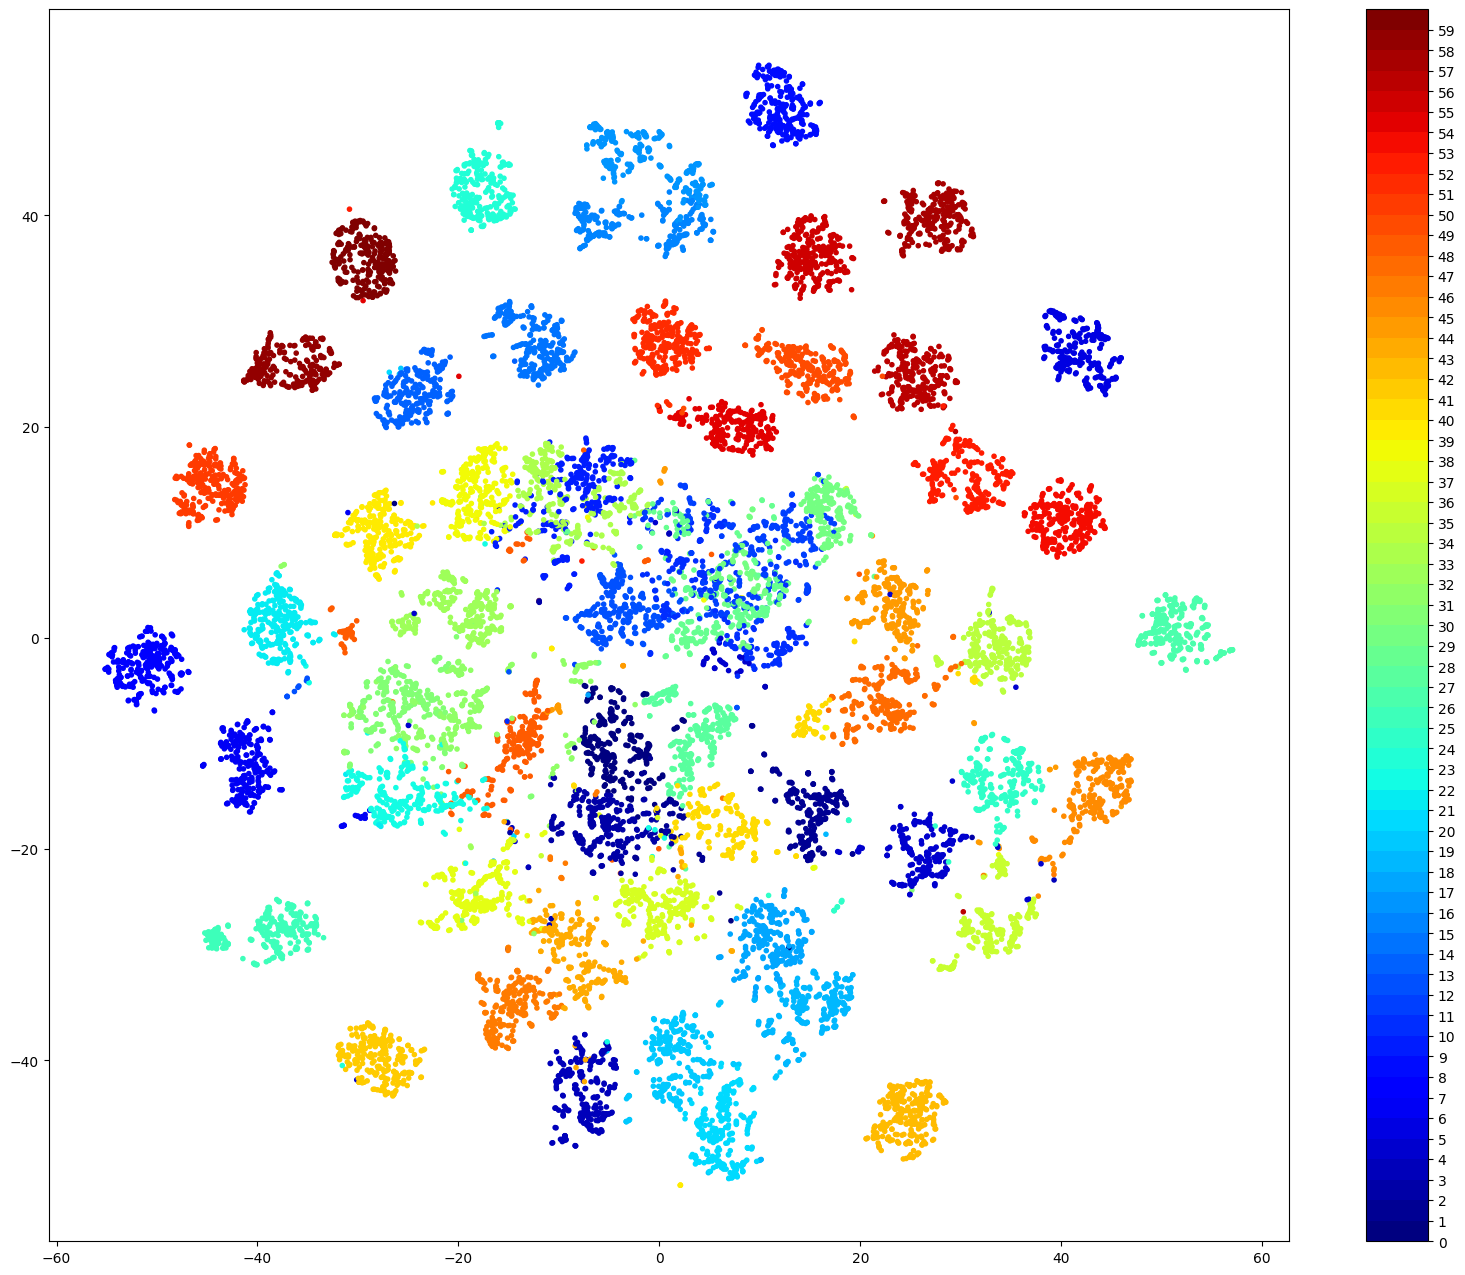

In [9]:
file_name = "new_features_space"

vis_latent_space(all_features.reshape(-1,60), all_labels, file_name)

In [10]:
all_features.reshape(-1,60).shape

torch.Size([16484, 60])

In [11]:
split_tensors = all_features.split(60, dim=0)

# Concatenate the split tensors along dimension 0
concatenated_tensor = torch.cat(split_tensors, dim=0)

concatenated_tensor.shape

torch.Size([16484, 60])

In [12]:
len(split_tensors)

275